In [1]:
import os
import time
import glob
import numba
import random
import itertools
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [3]:
torch.__version__

'1.11.0+cu113'

In [4]:
DATA_PATH = '../model/'
RANDOM_SEED = 42

In [5]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
seed_everything(RANDOM_SEED)

In [7]:
# @numba.jit
def stress_pos(x):
    try:
        res = np.zeros(len(x)-1)
        stress_idx = x.find('+')
        res[stress_idx] = 1
        return res
    except IndexError:
        return np.NaN

In [8]:
def replace_accents(x):
    chars = list(x.encode('utf-8').replace(b'\xcc\x81', b'+').decode('utf-8'))

    final_chars = []
    for i, c in enumerate(chars):
        if c == '+':
            try:
                tmp = final_chars[i - 1]

                final_chars.pop()
                final_chars.append('+')
                final_chars.append(tmp)
            except IndexError:
                final_chars.append(c)
        else:
            final_chars.append(c)

    return ''.join(final_chars)

In [9]:
data = []

for file in tqdm(glob.glob(DATA_PATH + "*.txt")):
    with open(file) as fil:
        lines = fil.readlines()
        for line in lines:
            try:
                word2 = line.strip()
                word2 = replace_accents(word2)
                word1 = word2.replace("+","")
                word1, word2 = word1.strip().replace('i', 'і'), word2.strip().replace('i', 'і')
                data.append((word1, word2))
            except ValueError:
                continue

100%|██████████| 1/1 [00:09<00:00,  9.58s/it]


In [10]:
data = pd.DataFrame(data)
data.columns = ['word', 'word_with_stress']

In [11]:
exclude_list = [
    '\t', '$', '%', '-', '\\', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 
    'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 
    'v', 'w', 'x', 'y', 'z', '~', '\xa0', '\xad', '·', 'ђ', 'ј', 'љ', 'њ', 'ћ', 
    'ў', 'џ', '–', '‘', '’', '“', '”', '•', '№',
    'ъ', 'ы', 'э'
]

for item in tqdm(exclude_list):
    data = data.loc[~data.word.str.contains(item, regex=False)]

100%|██████████| 53/53 [00:54<00:00,  1.03s/it]


In [12]:
%%time

data['word_list'] = data.word.map(list)

CPU times: user 6.42 s, sys: 492 ms, total: 6.91 s
Wall time: 6.89 s


In [13]:
%%time

data['word_stress_pos'] = data.word_with_stress.map(stress_pos)

CPU times: user 3.06 s, sys: 63.6 ms, total: 3.13 s
Wall time: 3.13 s


In [14]:
data = data.loc[data.word_stress_pos.notna()]

In [15]:
data.sample(5)

,word,word_with_stress,word_list,word_stress_pos
2906284,шкитильгатимете,шкитильг+атимете,"[ш, к, и, т, и, л, ь, г, а, т, и, м, е, т, е]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1285208,надгризи,надгр+изи,"[н, а, д, г, р, и, з, и]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
219867,вгнімось,вгн+імось,"[в, г, н, і, м, о, с, ь]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
648244,достарчиш,дост+арчиш,"[д, о, с, т, а, р, ч, и, ш]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
2505282,сталінку,ст+алінку,"[с, т, а, л, і, н, к, у]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [16]:
max_sequence_len = np.max(data.word.str.len())
max_sequence_len

29

In [17]:
def flatten(array):
    for item in array:
        if isinstance(item, list):
            yield from flatten(item)
        else:
            yield item


class SequenceTokenizer:
    
    def __init__(self):
        self.word2index = {}
        self.index2word = {}
        self.oov_token ='<UNK>'
        self.oov_token_index = 0
        
    def fit(self, sequence):
        self.index2word = dict(enumerate([self.oov_token] + sorted(set(flatten(sequence))), 1))
        self.word2index = {v:k for k,v in self.index2word.items()}
        self.oov_token_index = self.word2index.get(self.oov_token)
        return self
    
    def transform(self, X):
        res = []
        for line in X:
            res.append([self.word2index.get(item, self.oov_token_index) for item in line])
        return res

In [18]:
tokenizer = SequenceTokenizer()
tokenizer.fit(data.word_list);

In [19]:
tokenizer.word2index

{'<UNK>': 1,
 "'": 2,
 'а': 3,
 'б': 4,
 'в': 5,
 'г': 6,
 'д': 7,
 'е': 8,
 'ж': 9,
 'з': 10,
 'и': 11,
 'й': 12,
 'к': 13,
 'л': 14,
 'м': 15,
 'н': 16,
 'о': 17,
 'п': 18,
 'р': 19,
 'с': 20,
 'т': 21,
 'у': 22,
 'ф': 23,
 'х': 24,
 'ц': 25,
 'ч': 26,
 'ш': 27,
 'щ': 28,
 'ь': 29,
 'ю': 30,
 'я': 31,
 'є': 32,
 'і': 33,
 'ї': 34,
 'ґ': 35}

In [20]:
X = tokenizer.transform(data.word_list)

In [21]:
def pad_sequence(lst, max_seq=max_sequence_len):
    if isinstance(lst[0], list):
        return np.array([i + [0]*(max_seq-len(i)) for i in lst])
    else:
        lst + [0]*(max_seq-len(lst))

In [22]:
# %%time

# input_seq = zip(*itertools.zip_longest(*X, fillvalue=0))
# input_seq = list(map(list, input_seq))
# input_seq = np.array(input_seq)

In [23]:
%%time

input_seq = pad_sequence(X)

CPU times: user 10.9 s, sys: 340 ms, total: 11.2 s
Wall time: 11.2 s


In [24]:
print(input_seq.shape)
input_seq

(2960052, 29)


array([[ 3,  0,  0, ...,  0,  0,  0],
       [ 3,  3, 14, ...,  0,  0,  0],
       [ 3,  3, 14, ...,  0,  0,  0],
       ...,
       [35, 22, 19, ...,  0,  0,  0],
       [35, 22, 19, ...,  0,  0,  0],
       [35, 22, 19, ...,  0,  0,  0]])

In [25]:
y = data.word_stress_pos.values

In [26]:
output_seq = zip(*itertools.zip_longest(*y, fillvalue=0))
output_seq = list(map(list, output_seq))
output_seq = np.array(output_seq).astype(int)

In [27]:
print(output_seq.shape)
output_seq

(2960052, 29)


array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
(input_seq_train, input_seq_val, 
 output_seq_train, output_seq_val) = train_test_split(input_seq, 
                                                      output_seq, 
                                                      test_size=0.5, 
                                                      random_state=RANDOM_SEED)

In [29]:
input_seq_train = torch.tensor(input_seq_train, dtype=torch.long).cuda()
input_seq_val = torch.tensor(input_seq_val, dtype=torch.long).cuda()
output_seq_train = torch.tensor(output_seq_train, dtype=torch.float).cuda()
output_seq_val = torch.tensor(output_seq_val, dtype=torch.float).cuda()

In [30]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        data,target = self.dataset[index]
        return data, target, index
    
    def __len__(self):
        return len(self.dataset)

In [31]:
class LSTM_model(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=self.embeddings.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(self.hidden_dim * 4 , 64)
        self.batch_norm = nn.BatchNorm1d(self.hidden_dim * 4, affine=False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, target_size)

    def forward(self, x):
        h_embeddings = self.embeddings(x)
        
        h_lstm, _ = self.lstm(h_embeddings)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        x = torch.cat((avg_pool, max_pool), 1)
        x = self.batch_norm(x)
        x = self.linear(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.out(x)
        y = nn.functional.softmax(x, dim=1)
        return y

In [32]:
model = LSTM_model(embedding_dim=64, 
                   hidden_dim=64, 
                   vocab_size=len(tokenizer.word2index) + 1, 
                   target_size=max_sequence_len)
model.cuda()

LSTM_model(
  (embeddings): Embedding(36, 64)
  (lstm): LSTM(64, 64, num_layers=3, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (out): Linear(in_features=64, out_features=29, bias=True)
)

In [33]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [34]:
BATCH_SIZE = 256 * 2

train = MyDataset(torch.utils.data.TensorDataset(input_seq_train, output_seq_train))
valid = MyDataset(torch.utils.data.TensorDataset(input_seq_val, output_seq_val))

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
# with torch.no_grad():
#     (x_sample, y_sample, index) = train[:2]
#     preds = model(x_sample.reshape(1, -1))
#     print(preds.shape)

### K-Fold training

In [36]:
from sklearn.model_selection import KFold

In [37]:
n_folds = 5

In [38]:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
# kf.get_n_splits(X=input_seq, y=output_seq)

In [39]:
for train_index, test_index in kf.split(X=input_seq, y=output_seq):
    print(train_index.shape, test_index.shape)

(2368041,) (592011,)
(2368041,) (592011,)
(2368042,) (592010,)
(2368042,) (592010,)
(2368042,) (592010,)


In [40]:
input_seq

(2960052, 29)

### Training loop

In [41]:
n_epochs = 50
history = {'train': {}, 'val': {}}
teacher_forcing_ratio = 0.5

for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    
    model.train()

    avg_loss, total_loss, avg_acc, total_acc = 0., 0., 0., 0.
    for i, (x_batch, y_batch, index) in enumerate(train_loader):
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        equal = torch.eq(torch.argmax(y_pred, axis=1), torch.argmax(y_batch, axis=1))
        batch_acc = int(equal.sum(-1)) / y_batch.shape[0]
        batch_loss = loss.item()
        
        total_acc += batch_acc
        total_loss += batch_loss
        print(f"\rEpoch [{epoch}/{n_epochs}] "
              f" progress = {round(i/len(train_loader)*100)}% "
              f"\t loss={total_loss / (i + 1):.4f} "
              f"\t acc={total_acc / (i + 1) * 100:.2f}% ", end='')
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    history['train']['loss'] = history.get('train', {}).get('loss', []) + [avg_loss]
    history['train']['accuracy'] = history.get('train', {}).get('accuracy', []) + [avg_acc]
        
    model.eval()

    
    avg_val_loss, total_val_loss, avg_val_acc, total_val_acc = 0., 0., 0., 0.
    for i, (x_batch, y_batch, index) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        val_loss = loss_function(y_pred, y_batch)
        
        equal = torch.eq(torch.argmax(y_pred, axis=1), torch.argmax(y_batch, axis=1))
        batch_val_acc = int(equal.sum(-1)) / y_batch.shape[0]
        batch_val_loss = val_loss.item()
        
        total_val_acc += batch_val_acc
        total_val_loss += batch_val_loss
    avg_val_loss = total_val_loss / len(valid_loader)
    avg_val_acc = total_val_acc / len(valid_loader)
    history['val']['loss'] = history.get('val', {}).get('loss', []) + [avg_val_loss]
    history['val']['accuracy'] = history.get('val', {}).get('accuracy', []) + [avg_val_acc]
    
    elapsed_time = time.time() - start_time 
    print(f"\nEpoch [{epoch}/{n_epochs}]  results:"
          f"\t\t loss={avg_loss:.4f}"
          f"\t acc={avg_acc * 100:.2f}%"
          f"\t val_loss={avg_val_loss:.4f}"
          f"\t val_acc={avg_val_acc * 100:.2f}%"
          f"\t time={elapsed_time:.2f}s")
    print("-"*78)

Epoch [1/50]  progress = 100% 	 loss=0.6920 	 acc=65.04% 
Epoch [1/50]  results:		 loss=0.6920	 acc=65.04%	 val_loss=0.6884	 val_acc=75.71%	 time=91.47s
------------------------------------------------------------------------------
Epoch [2/50]  progress = 100% 	 loss=0.6880 	 acc=76.95% 
Epoch [2/50]  results:		 loss=0.6880	 acc=76.95%	 val_loss=0.6874	 val_acc=78.65%	 time=91.03s
------------------------------------------------------------------------------
Epoch [3/50]  progress = 100% 	 loss=0.6873 	 acc=78.94% 
Epoch [3/50]  results:		 loss=0.6873	 acc=78.94%	 val_loss=0.6872	 val_acc=79.29%	 time=89.76s
------------------------------------------------------------------------------
Epoch [4/50]  progress = 100% 	 loss=0.6869 	 acc=80.04% 
Epoch [4/50]  results:		 loss=0.6869	 acc=80.04%	 val_loss=0.6868	 val_acc=80.37%	 time=91.21s
------------------------------------------------------------------------------
Epoch [5/50]  progress = 100% 	 loss=0.6866 	 acc=81.05% 
Epoch [5/50]  

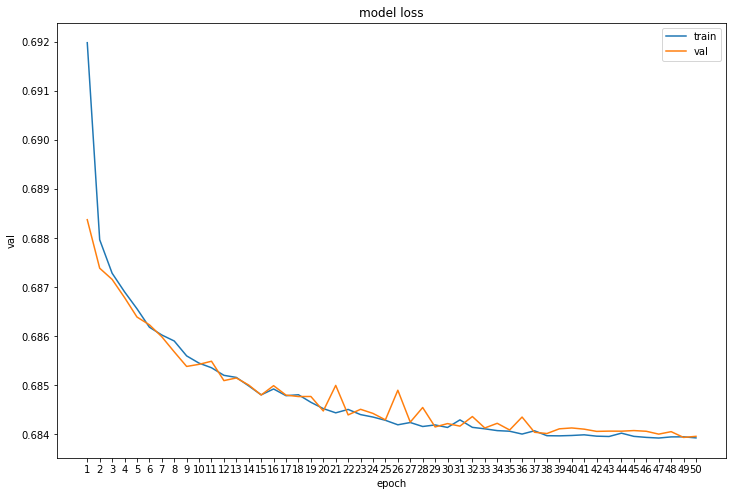

In [42]:
plt.figure(figsize=(12, 8))

plt.plot(history['train']['loss'])
plt.plot(history['val']['loss'])
plt.title('model loss')
plt.ylabel('val')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history['train']['loss'])), np.arange(1, len(history['train']['loss']) + 1))
plt.legend(['train', 'val'], loc='upper right')

plt.show()

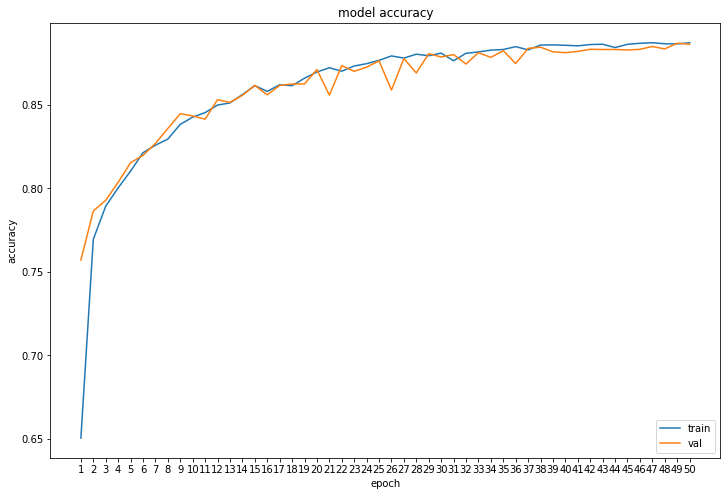

In [43]:
plt.figure(figsize=(12, 8))

plt.plot(history['train']['accuracy'])
plt.plot(history['val']['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(len(history['train']['accuracy'])), np.arange(1, len(history['train']['accuracy']) + 1))
plt.legend(['train', 'val'], loc='lower right')

plt.show()

### Predict

In [44]:
def predict(words, mode='stress'):
    tokens = pad_sequence(tokenizer.transform(words))
    sequences = torch.tensor(tokens, dtype=torch.long).cuda()
    preds = model(sequences)
    indeces = torch.argmax(preds, axis=1)
    if mode == 'stress':
        return [word[:index+1] + chr(769) + word[index+1:] for word, index in zip(words, indeces)]
    elif mode == 'asterisk':
        return [word[:index+1] + "*" + word[index+1:] for word, index in zip(words, indeces)]
    else:
        raise ValueError(f"Wrong `mode`={mode}")

In [45]:
words = ["словотворення", "архаїчний"]

In [46]:
predict(words)

['словотво́рення', 'архаї́чний']

In [47]:
torch.save(model.state_dict(),"accentor.pt")